In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.stats.api as sms

import scipy.stats as stats
import math
import seaborn as sns

plt.rcParams['axes.facecolor'] = 'white'

# Data Exploration

Read our data

In [3]:
data= pd.read_csv('data\AdSmartABdata.csv')
data.sample(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
5112,a2a8bc7e-f4e0-4302-8cdf-7b4f5ba8f723,control,2020-07-04,1,VKY-L09,6,Facebook,0,0
7989,fc902c99-7189-4950-8eee-194a23bd0e0c,control,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
3383,6d46a7c0-27d9-4156-bb04-64dd087f6a8a,exposed,2020-07-06,10,Samsung SM-N950F,6,Facebook,1,0
5625,b214b5f6-2ba0-4e39-8059-d15be0d78e5f,control,2020-07-08,20,Generic Smartphone,6,Chrome Mobile,0,0
5353,a94bb009-0425-42fb-bd53-c56ff7b79405,control,2020-07-08,15,Nokia undefined$2$3,6,Chrome Mobile,0,0


See the number of data points and the number of features

In [4]:
print(f" There are {data.shape[0]} rows and {data.shape[1]} columns")


 There are 8077 rows and 9 columns


See the number of null values to see if the data needs cleaning

In [5]:
data.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

Unique values for each column

In [6]:

data.nunique()

auction_id     8077
experiment        2
date              8
hour             24
device_make     270
platform_os       3
browser          15
yes               2
no                2
dtype: int64

See the number of experimental and control data points

In [7]:
data.groupby("experiment")["experiment"].count()

experiment
control    4071
exposed    4006
Name: experiment, dtype: int64

See the number of people who actually responded to the survey

In [8]:
responded=data.loc[(data["yes"]==1) | (data["no"]==1)]
print(f" There are number of respondents is {responded.shape[0]}")

 There are number of respondents is 1243


See the number of unique users who responded. We can see that every respondent is unique so we don't have to remove any datapoint

In [9]:
responded["auction_id"].nunique()

1243

See the unique values for every colum

In [10]:
responded.nunique()

auction_id     1243
experiment        2
date              8
hour             24
device_make     115
platform_os       2
browser           8
yes               2
no                2
dtype: int64

See data types

In [11]:
responded.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

See the groups used in our test

In [12]:
responded["experiment"].unique()

array(['exposed', 'control'], dtype=object)

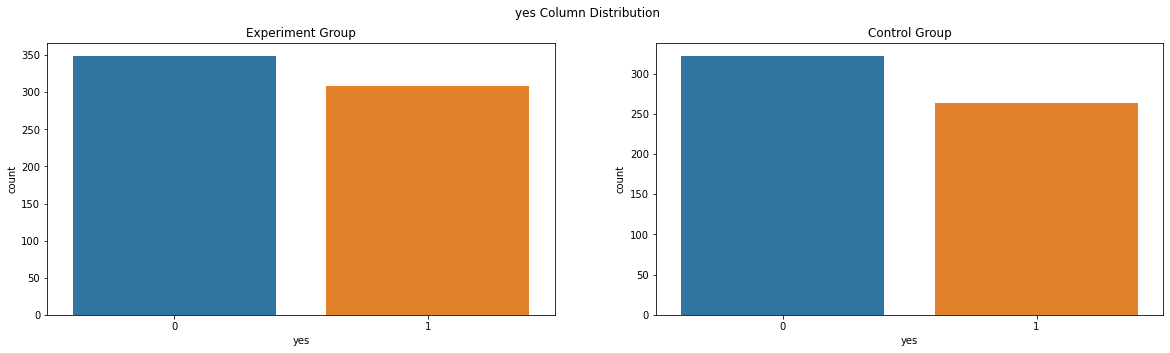

In [13]:
#Function to draw bar plots of the exposed and control
def bar_plot(data,column):
    fig, axs = plt.subplots(1,2,figsize=(20,5))
    fig.suptitle(f'{column} Column Distribution')
    sns.countplot(x=column, data=data[data["experiment"]=="exposed"],ax=axs[0]).set_title('Experiment Group')
    
    sns.countplot(x=column, data=data[data["experiment"]=="control"],ax=axs[1]).set_title('Control Group')

bar_plot(responded,"yes")

Platform distribution across the two groups. There is a slighly higher proportion of users using platform 5

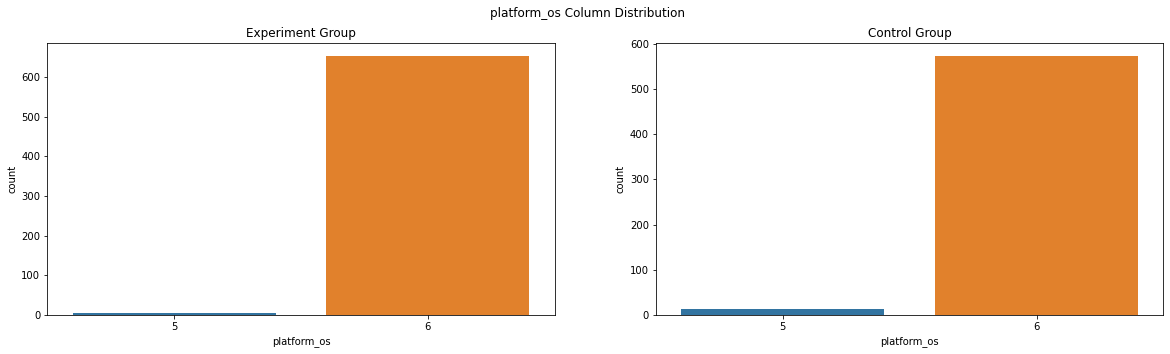

In [14]:

bar_plot(responded,"platform_os")

The survey respnse date distributions. We can see that the distributions are more even in our experiment group than in our control group. The control group has a spike of responses on 07/03/2020

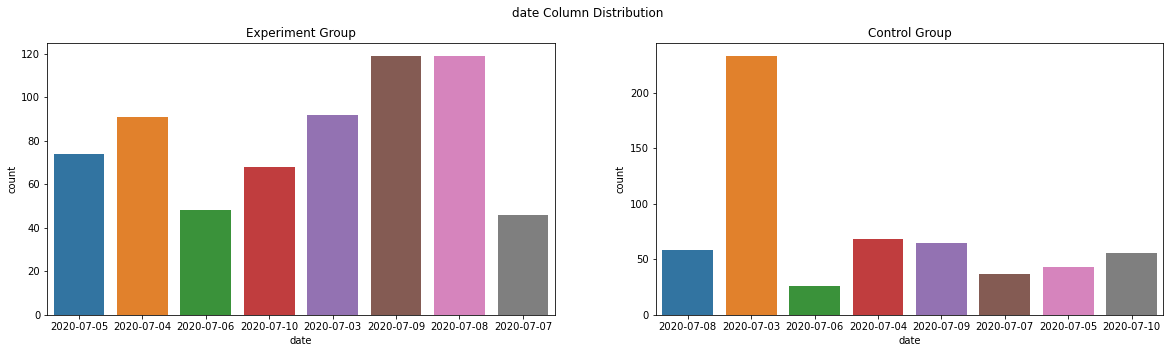

In [15]:
bar_plot(responded,"date")

The distribution of operating systems between the experimental and control groups. 

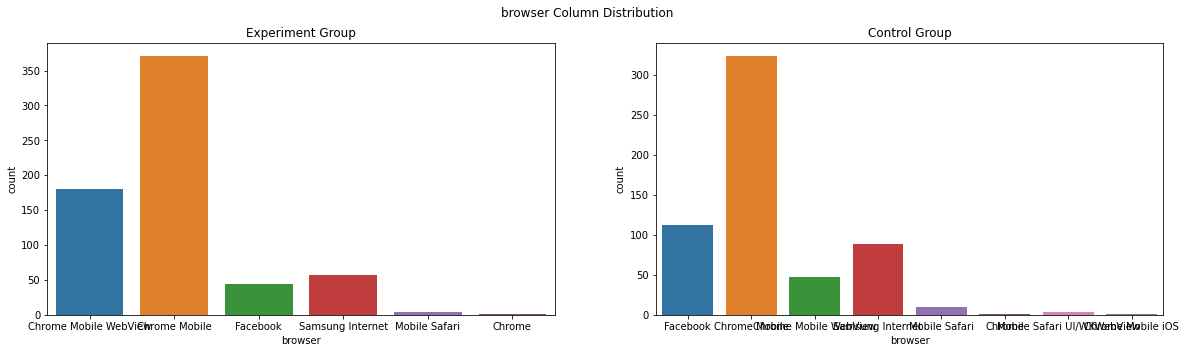

In [16]:
bar_plot(responded,"browser")

The distribution of response hours between the experimental and control groups. We see that the response on the experiment group is different ot the distribution of the control group. The control group has a concentration of responses on 3 PM. This uptick accounts for a large percentage of our responses.

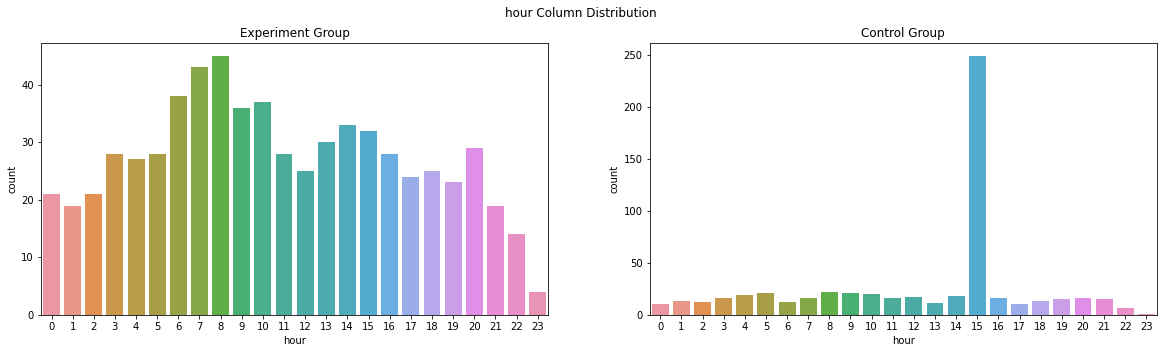

In [17]:
bar_plot(responded,"hour")

The number of exposed(experiment ) or control group proportion in the responses. We have slightly more exposed group responses than control ones

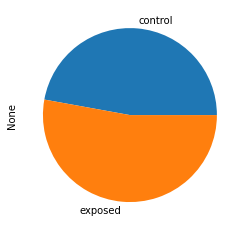

In [18]:
responded.groupby(responded.experiment).size().plot(kind='pie').set_facecolor("white")

Correlation analysis of the different columns. Only yes and no have any correlation because they represent the opposites of the Bernoulli process that generates them

<AxesSubplot:>

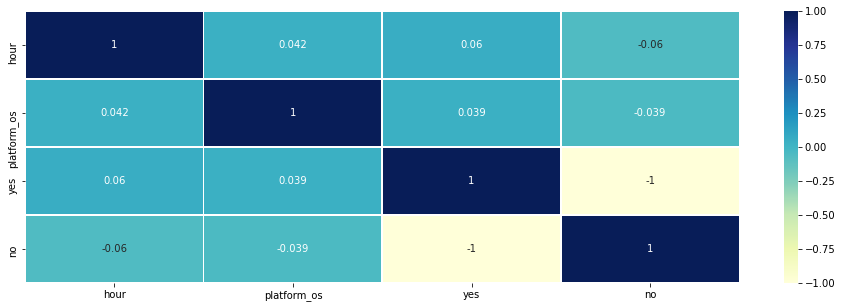

In [19]:

plt.figure(figsize=(16, 5))
sns.heatmap(responded.corr(method='pearson'), cmap="YlGnBu", annot=True,linewidths=.5)

Count of the repondents who said yes in each group

In [20]:
responded.groupby("experiment")["yes"].sum()

experiment
control    264
exposed    308
Name: yes, dtype: int64

Number of respondents in each experimental group

In [21]:
responded.groupby("experiment")["experiment"].count()

experiment
control    586
exposed    657
Name: experiment, dtype: int64

Plot to show proportion of awarness in the control and exposed groups

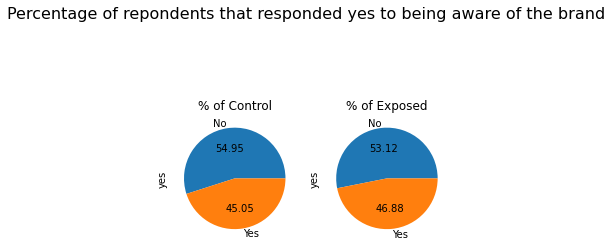

In [22]:

fig, axes = plt.subplots(1, 2)
fig.suptitle('Percentage of repondents that responded yes to being aware of the brand', fontsize=16)

responded.loc[responded["experiment"] =="control"]['yes'].value_counts().plot( kind='pie', figsize=(5,5), fontsize=10, 
                                              labels = ['No', 'Yes'], autopct='%.2f', ax=axes[0])
axes[0].set_title('% of Control', fontsize = 12)

responded.loc[responded["experiment"] =="exposed"]['yes'].value_counts().plot( kind='pie', figsize=(5,5), fontsize=10, 
                                              labels = ['No', 'Yes'], autopct='%.2f', ax=axes[1])
axes[1].set_title('% of Exposed', fontsize = 12)
plt.show()


# Classical Hypothesis Testing

In [23]:
users = pd.DataFrame(data = responded[["auction_id", "experiment"]])
users["converted"] = responded.yes

In [24]:
conversion_rates = users.groupby('experiment')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p,"sum","count"])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error',"converted","count"]


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error,converted,count
experiment,,,,,
control,0.451,0.498,0.021,264.000,586.000
exposed,0.469,0.499,0.019,308.000,657.000


Conversion rates comparison

Text(0, 0.5, 'Converted (proportion)')

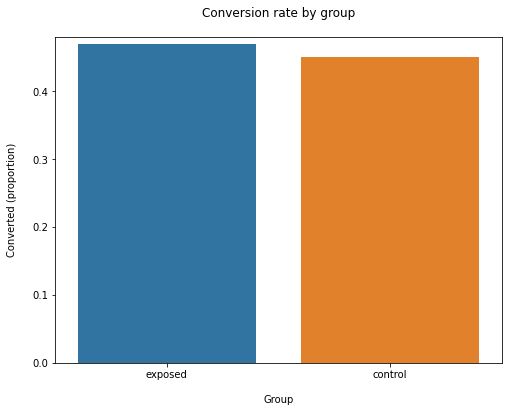

In [25]:
plt.figure(figsize=(8,6))

sns.barplot(x=users['experiment'], y=users['converted'], ci=False)

plt.ylim(0, 0.48)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

The minimum number of observations required to detect the effect

In [26]:
effect_size = sms.proportion_effectsize(0.45, 0.469)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = math.ceil(required_n)                          # Rounding up to next whole number                          

print("Number of required Observations per group is ",required_n)

Number of required Observations per group is  10799


<p style="font-size:20px">The minimum number of observations for each the exposed and the control group is 10799, or we need a total of 21,598 total responses evenly distibuted between our control and exposed groups</p>

Hypothesis testing code Adapted from [here](https://medium.com/@RenatoFillinich/ab-testing-with-python-e5964dd66143#:~:text=from%20statsmodels.stats.proportion%20import%20proportions_ztest%2C)

In [27]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = users[users['experiment'] == 'control']['converted']
treatment_results = users[users['experiment'] == 'exposed']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.65
p-value: 0.518
ci 95% for control group: [0.410, 0.491]
ci 95% for treatment group: [0.431, 0.507]


<p style="font-weight:700;font-size:30px">As we can see the p value is above our significance level so we accept our null hypthesis that there is no significant lift. But our conclusion has low power because we have not met the minimum number of samples for the specific difference level in awareness and power as calculate in previous cells</p>

Plot of the probability distributions

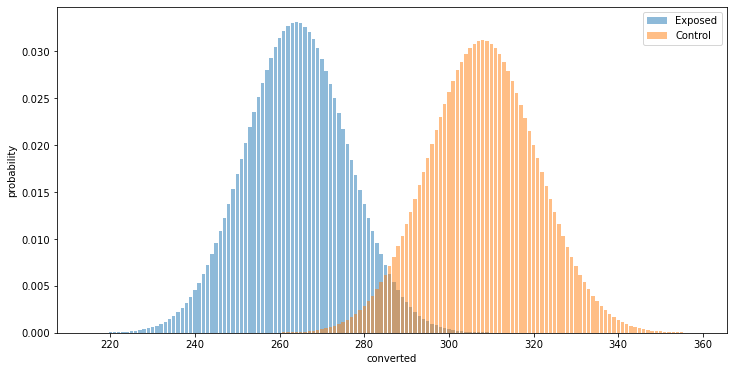

In [28]:

fig, ax = plt.subplots(figsize=(12,6))
A_converted=conversion_rates.loc["control"]["converted"]
B_converted=conversion_rates.loc["exposed"]["converted"]
p_A=conversion_rates.loc["control"]["conversion_rate"]
p_B=conversion_rates.loc["exposed"]["conversion_rate"]
A_total=conversion_rates.loc["control"]["count"]
B_total=conversion_rates.loc["exposed"]["count"]

xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = stats.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5,label="Exposed")
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = stats.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5,label="Control")
# ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--'.label="")
plt.xlabel('converted')
plt.ylabel('probability')

plt.legend()


sequential

# Sequential Testing

In [29]:
def ConditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
    if t1<=1:
        print('warning',"Odd ratio should exceed 1.")
    if (alpha >0.5) | (beta >0.5):
        print('warning',"Unrealistic values of alpha or beta were passed."
                    +" You should have good reason to use large alpha & beta values")
    if stop!=None:
        stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)
    
    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        """
        #
        # Meeker's (1981) function `g`, the log probability ratio.
        # 
        """
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
        """
        #
        # Reciprocal of Meeker's (1981) function `h`: the conditional probability of 
        # `x` given `r` and `n`, when the odds ratio is `t`.
        #
        # `x` is his "x1", the number of positives in `n` control trials.
        # `r` is the total number of positives.
        # `n` is the number of (control, treatment) pairs.
        # `t` is the odds ratio.
        #
        """
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        """#
        # Meeker's (1981) function exp(F(r,n,t)), proportional to the probability of 
        #  `r` (=x1+x2) in `n` paired trials with an odds ratio of `t`.
        #
        # This function does *not* vectorize over its arguments.
        #"""
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
        """
        #
        # Up to an additive constant, the log probability that (x1, x1+x2) = (j, r) 
        # in `n` paired trials with odds ratio of `t`.
        #
        # `offset` is used to adjust the result to avoid under/overflow.
        #
        """
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):
        """
        #
        # A protected vesion of log(f), Meeker's function `F`.
        #
        """
        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
        """
        #
        # Meeker's (1981) functions c_L(r,n) and c_U(r,n), the  critical values for x1.
        # 0 <= r <= 2n; t1 >= t0 > 0.
        #
        """
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

    l=math.log(beta/(1-alpha))
    u=-math.log(alpha/(1-beta))
    sample_size=min(len(x),len(y))
    n=np.array(range(1,sample_size+1))

    if stop!=None:
        n=np.array([z for z in n if z<=stop])
    x1=np.cumsum(x[n-1])
    r=x1+np.cumsum(y[n-1])
    stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
        #
        # Perform the test by finding the first index, if any, at which `stats`
        # falls outside the open interval (l, u).
        #
    clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
    limits=[]
    for v in clu:
        inArray=[]
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits=np.array(limits)

    k=np.where((stats>=u) | (stats<=l))
    cvalues=stats[k]
    if cvalues.shape[0]<1:
        k= np.nan
        outcome='Unable to conclude.Needs more sample.'
    else:
        k=np.min(k)
        if stats[k]>=u:
            outcome=f'Exposed group produced a statistically significant increase.'
        else:
            outcome='Their is no statistically significant difference between two test groups'
    if (stop!=None) & (k==np.nan):
        #
        # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
        # Leave k=NA to indicate the decision was made due to truncation.
        #
        c1=clowerUpper(r,stop,t1,alpha,beta)
        c1=math.floor(np.mean(c1)-0.5)
        if x1[n0]<=c1:
            truncate_decision='h0'
            outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision='h1'
            outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated=stop
    else:
        truncate_decision='Non'
        truncated=np.nan
    return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [30]:
test=responded.copy()
def transform_data(df):
    df["datehour"]=pd.to_datetime(df.date) + pd.to_timedelta(df.hour, unit='h')

    df.datehour.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

    expo=df.loc[df["experiment"] == "exposed"]
    contro=df.loc[df["experiment"] =="control"]

    engagement_sucess_exposed=expo.sort_values("datehour").groupby("datehour",as_index=False)["yes"].agg(["count","sum"])
    engagement_sucess_control=contro.sort_values("datehour").groupby("datehour",as_index=False)["yes"].agg(["count","sum"])
    def rand_bin_array(x):
        arr = np.zeros(x[0])
        arr[:x[1]]  = 1
        np.random.shuffle(arr)
        return arr

    e=engagement_sucess_exposed.apply(rand_bin_array, axis=1).to_numpy()
    
    c=engagement_sucess_control.apply(rand_bin_array, axis=1).to_numpy()

    return e,c


In [31]:

def transform_data_2(df):
    df["datehour"]=pd.to_datetime(df.date) + pd.to_timedelta(df.hour, unit='h')

    df.datehour.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

    expo=df.loc[df["experiment"] == "exposed"]
    contro=df.loc[df["experiment"] =="control"]
    expo=expo.sort_values("datehour")
    contro=contro.sort_values("datehour")

    e =expo["yes"].to_numpy()
    c =contro["yes"].to_numpy()
    return e,c

In [32]:
test=responded.copy()
x,y=transform_data_2(test)
outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits=ConditionalSPRT(x=x,y=y,t1=1.07)

# print(k)



The outcome of our sequential test

In [ ]:

print(outcome)

Unable to conclude.Needs more sample.


Plot of our sequential test

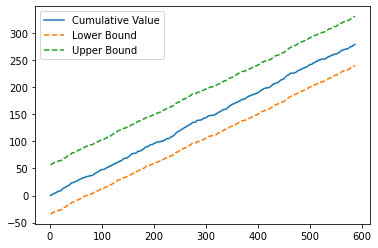

In [ ]:
plt.plot(n, x1, label = "Cumulative Value")
plt.plot(n, limits[:,0], label = "Lower Bound", linestyle='dashed')
plt.plot(n, limits[:,1], label = "Upper Bound", linestyle='dashed')
plt.legend()


<p style="font-weight:600;font-size:20px">As we can see the borders have not been crossed so we need more observations to say either way. In other words no conclusive effect can be found yet</p>

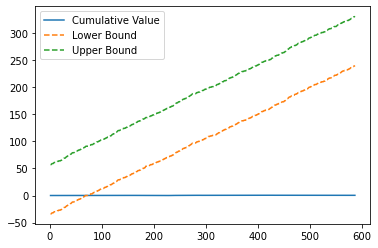

In [ ]:
# xaxis=np.linspace(0, n, num=n)
# plt.plot(n, stats, label = "Cumulative Value")
# plt.plot(n, limits[:,0], label = "Lower Bound", linestyle='dashed')
# plt.plot(n, limits[:,1], label = "Upper Bound", linestyle='dashed')
# plt.legend()

In [ ]:
print(stats[:50])


[ 0.          0.         -0.00091547  0.03260323  0.03249427  0.06599415
  0.06554597  0.03142616  0.03123769  0.03108891  0.06460704  0.09812953
  0.0639967   0.0975251   0.09736435  0.13088753  0.09675449  0.09659994
  0.09646211  0.12997699  0.09583598  0.129356    0.16287809  0.16243872
  0.19596965  0.19557123  0.16144915  0.16125052  0.19478471  0.1944029
  0.16028248  0.15992811  0.12581025  0.12547915  0.0913628   0.12490516
  0.09078891  0.12433136  0.15787385  0.19141638  0.19110842  0.15699288
  0.15669993  0.12258455  0.12230493  0.12203759  0.12173253  0.15527567
  0.12116016  0.12089132]


Data Manipulation


In [ ]:
# data_without_browser=data.copy()
# data_without_browser.drop("browser",axis=1,inplace=True)
# data_without_browser.to_csv("data/AdSmartABdata.csv")

In [ ]:
# data_without_os=data.copy()
# data_without_os.drop("platform_os",axis=1,inplace=True)
# data_without_os.to_csv("data/AdSmartABdata.csv")